# Cross-walking and DisMod-MR

This notebook provides some examples of cross-walking in descriptive epidemiological meta-regression.  In this context, cross-walking refers to mapping between two different, but related, quantities that have been measured.  For example, it is more accurate to directly measure blood pressure to test for hypertension, but it is cheaper to simply ask respondents if they have ever been told by a medical professional that they have high blood pressure.

It is possible to cross-walk inside DisMod-MR, but if sufficent information is available cross-walking outside of DisMod-MR can provide more flexibility to you, the analyst.

This notebook uses simulated data to compare simple approaches for cross-walking inside and outside of DisMod-MR.

In [1]:
import numpy as np, pandas as pd, dismod_mr

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set a random seed to ensure reproducible simulation results
np.random.seed(123456)

In [3]:
# simulate data
n = 20

data = dict(age=np.random.randint(0, 10, size=n)*10,
            year=np.random.randint(1990, 2010, size=n))
data = pd.DataFrame(data)

# in the simulation, some data will be measured, and some will be self-reported
# the self-reported data values will be shifted by N(-.25, .1) in log-space
data['self_report'] = np.random.randint(2, size=n)
data['beta_self_report'] = np.random.normal(-.25, .1, size=n)

data['true_value'] = (.1 + .001 * data.age) + np.random.normal(0., .01, size=n)
data['self_report_value'] = data.true_value * np.exp(data.beta_self_report)

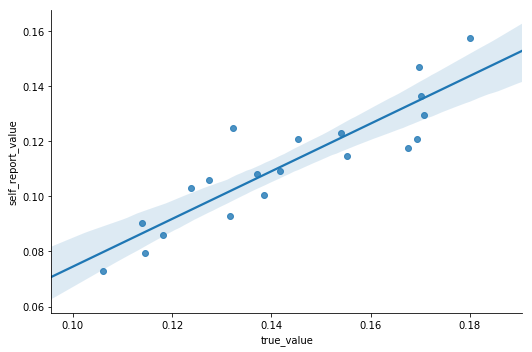

In [4]:
# let's see the difference between the (simulated) true value and self-report value

sns.lmplot('true_value', 'self_report_value', data, aspect=1.5);

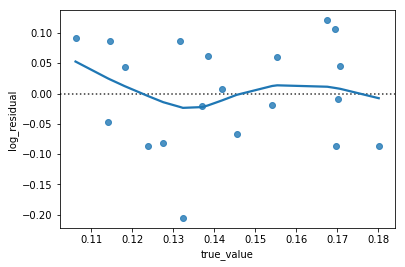

In [5]:
# to really see what is going on, it is better to look at residuals of some sort
data['log_residual'] = np.log(data.true_value) - np.log(data.self_report_value)
sns.residplot('true_value', 'log_residual', data, lowess=True);

In [6]:
data['data_type'] = 'p'

data['age_start'] = data.age
data['age_end'] = data.age+10

# for prettier display, include jittered age near midpoint of age interval
data['jittered_age'] = .5*(data.age_start + data.age_end) + np.random.normal(size=n)

# keep things simple, no spatial random effects, no sex effect
data['area'] = 'all'
data['sex'] = 'total'

# quantification of uncertainty that says these numbers are believed to be quite precise
data['standard_error'] = -99
data['upper_ci'] = np.nan
data['lower_ci'] = np.nan
data['effective_sample_size'] = 1.e8


def new_model(data):
    # build the dismod_mr model
    dm = dismod_mr.data.ModelData()

    # set simple model parameters, for decent, fast computation
    dm.set_knots('p', [0,100])
    dm.set_level_bounds('p', lower=0, upper=1)
    dm.set_level_value('p', age_before=0, age_after=100, value=0)
    dm.set_heterogeneity('p', value='Slightly')
    dm.set_effect_prior('p', cov='x_sex', value=dict(dist='Constant', mu=0))
    
    # copy data into model 
    dm.input_data = data.copy()
    
    return dm

Here is what things would look like if we had all measured values (`true_value`) or all self-reported values (`self_report_value`):

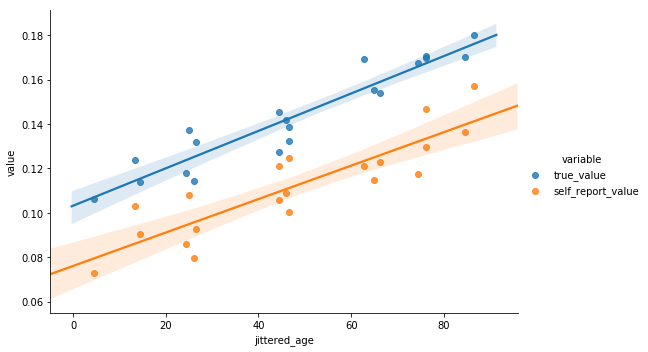

In [7]:
t = pd.melt(data, id_vars=['jittered_age'], value_vars=['true_value', 'self_report_value'])
sns.lmplot('jittered_age', 'value', t, hue='variable', aspect=1.5);

But often the dataset we find has no overlap, like this:

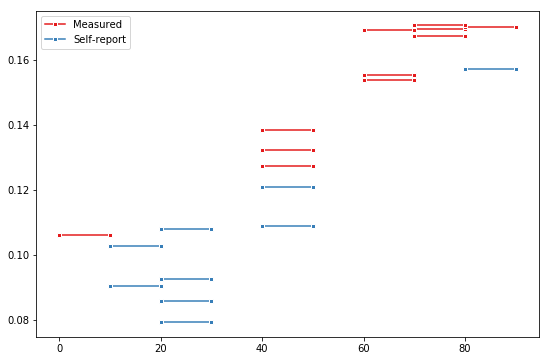

In [8]:
plt.figure(figsize=(9,6))

data['value'] = data.true_value
dismod_mr.plot.data_bars(data[data.self_report==0], color=dismod_mr.plot.colors[0], label='Measured')

data['value'] = data.self_report_value
dismod_mr.plot.data_bars(data[data.self_report==1], color=dismod_mr.plot.colors[1], label='Self-report')
plt.legend(loc='upper left');

If we had access to the true value, we would just fit that, and get nice results.

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values


/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/ihme/homes/

. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.03
sampling from posterior

CPU times: user 12.7 s, sys: 30.9 ms, total: 12.7 s
Wall time: 12.9 s


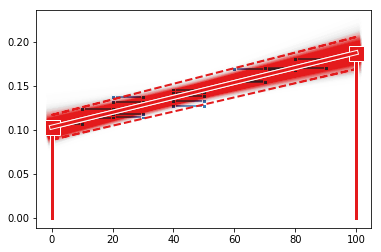

In [9]:
data['value'] = data.true_value
dm = new_model(data)

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
dm.plot()

If we have measurements of both the measured value and the self-reported for many data points, we could do a cross-walk outside of dismod and adjust all of the data with only self-reported measurements before building the DisMod-MR model:

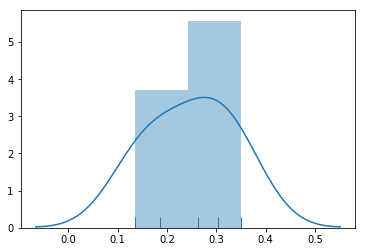

In [10]:
# simulate 20% portion of data with both measured and self-reported values

data['measured_both'] = np.random.randint(5, size=n) == 0

log_diff = np.log(data.true_value[data.measured_both]) - np.log(data.self_report_value[data.measured_both])
sns.distplot(log_diff, rug=True);

In [11]:
# use exp of mean of log(difference) to cross-walk self-reported data before building DisMod-MR model

data['cross_walked'] = data.self_report_value * np.exp(log_diff.mean())

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 13.4 s, sys: 69.8 ms, total: 13.4 s
Wall time: 13.5 s


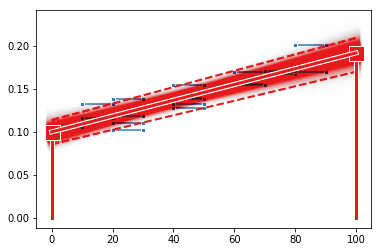

In [12]:
data['value'] = np.where(data.self_report==1, data.cross_walked, data.true_value)
dm = new_model(data)

dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
dm.plot()

With this simple model of a cross-walk, it would be equivalent to include the mean of the log-differences an informative prior on the self-report effect coefficient, which can be more convenient than shifting the data. Note the sign of the effect prior:

using stored FE for beta_p_x_self_report x_self_report {'dist': 'Constant', 'mu': -0.24727082612525764}
using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 12.8 s, sys: 52.6 ms, total: 12.8 s
Wall time: 12.8 s


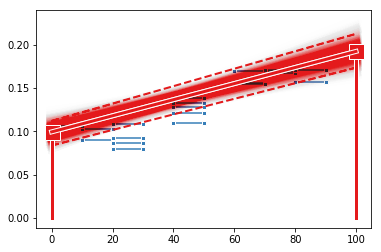

In [13]:
data['value'] = np.where(data.self_report==1, data.self_report_value, data.true_value)
data['x_self_report'] = data.self_report

dm = new_model(data)
dm.set_effect_prior('p', 'x_self_report',
                    dict(dist='Constant', mu=-log_diff.mean()))


dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
dm.plot()

Doing the cross-walk completely outside of DisMod-MR, and adjusting the data before building the model allows for more complicated cross-walk modeling, however, such as different cross-walk factors based on age or other relevant demographic variables.  (Of course, this requires more cross-walk-able data, and is a topic that we will not explore further here.)

If we have little or no studies that have reported both outcomes, we can cross-walk with DisMod-MR fixed effects:

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.05
sampling from posterior

CPU times: user 14.3 s, sys: 38.6 ms, total: 14.3 s
Wall time: 14.6 s


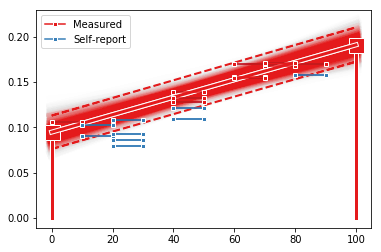

In [14]:
data['value'] = np.where(data.self_report==1, data.self_report_value, data.true_value)
data['x_self_report'] = data.self_report

dm = new_model(data)
dm.setup_model('p', rate_model='neg_binom')

%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
dm.plot()

data['value'] = data.true_value
dismod_mr.plot.data_bars(data[data.x_self_report==0], color=dismod_mr.plot.colors[0], label='Measured')

data['value'] = data.self_report_value
dismod_mr.plot.data_bars(data[data.x_self_report==1], color=dismod_mr.plot.colors[1], label='Self-report')
plt.legend(loc='upper left');

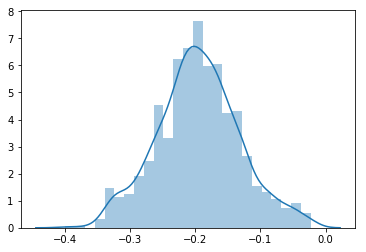

In [15]:
sns.distplot(dm.vars['p']['beta'][0].trace())

It is sometimes helpful to include informative priors on the effect coefficients, for example if it is known that the self-report outcome is always less than the direct measurement.

DisMod-MR has three distributions that may be used as an informative prior on a 

This can also be used to combine a cross-walk outside of DisMod-MR with a tune-up inside of the model:

using stored FE for beta_p_x_self_report x_self_report {'dist': 'TruncatedNormal', 'mu': -0.24727082612525764, 'sigma': 0.08713087780064908, 'lower': -0.25, 'upper': -0.2}
using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.05
sampling from posterior

CPU times: user 12.6 s, sys: 38.8 ms, total: 12.6 s
Wall time: 13.1 s


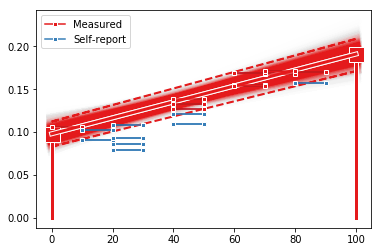

In [16]:
data['value'] = np.where(data.self_report==1, data.self_report_value, data.true_value)

dm = new_model(data)
dm.set_effect_prior('p', 'x_self_report',
                    dict(dist='TruncatedNormal', mu=-log_diff.mean(), sigma=log_diff.std(), lower=-.25, upper=-.2))


dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2000, burn=1000, thin=1)
dm.plot()

data['value'] = data.true_value
dismod_mr.plot.data_bars(data[data.x_self_report==0], color=dismod_mr.plot.colors[0], label='Measured')

data['value'] = data.self_report_value
dismod_mr.plot.data_bars(data[data.x_self_report==1], color=dismod_mr.plot.colors[1], label='Self-report')
plt.legend(loc='upper left');

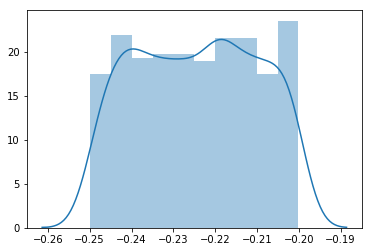

In [17]:
sns.distplot(dm.vars['p']['beta'][0].trace())

In [18]:
!date

Mon Jun 17 17:28:48 PDT 2019
